# Importing libraries

In [114]:
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks, freqz
from scipy.io.wavfile import write
from librosa import feature 
from hmmlearn import hmm

In [159]:
pathToData = r"C:\\Users\\HP\\Downloads\\Commands Dataset"
pathToTrainingData = pathToData+"\\train"
pathToCleanTest = pathToData+"\\test_clean"
pathToNoisyTest = pathToData

Applying pre-emphasis to the signal

We can do this by passing the signal througha filter : 
$$H(z) = (1 - \alpha z^{-1}) \text{ with $\alpha$ very close to 1, typically = 0.95}$$
$$\implies y[n] = x[n] - \alpha x[n-1]$$

In [3]:
def applyPreEmphasis(data, alpha = 0.95):
    alpha = 0.95#choosing the zero for pre-emphasis
    dataPreEmph = np.array([data[n] - alpha*data[n-1] for n in range(1, len(data))])#gives singal from n=1 since we start from 1
    dataPreEmph = np.insert(dataPreEmph, 0, data[0])#intial value is same as that of x[0]
    return dataPreEmph

In [4]:
trainingData = {}
for label in os.listdir(pathToTrainingData):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToTrainingData+"\\"+label):
        sampleRate, data = wavfile.read(pathToTrainingData+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    trainingData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


In [160]:
testCleanData = {}
for label in os.listdir(pathToCleanTest):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToCleanTest+"\\"+label):
        sampleRate, data = wavfile.read(pathToCleanTest+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    testCleanData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


---

In [ ]:
acc = 0
for i in range(0, data.shape[0]-1):
    acc += np.abs(np.sign(data[i+1]) - np.sign(data[i]))

In [29]:
ff =np.array([1,2,-3,4,5,-6,-2,-6,2])
acc = 0
for i in range(0, ff.shape[0]-1):
    acc += np.abs(np.sign(ff[i+1]) - np.sign(ff[i]))

In [30]:
acc

8

In [26]:
(data[:-1]*data[1:]<0).sum()

3099

In [28]:
data

array([0.00045778, 0.00088504, 0.00045778, ..., 0.02966399, 0.03326518,
       0.02850429])

In [27]:
data[:-1]

array([0.00045778, 0.00088504, 0.00045778, ..., 0.0143437 , 0.02966399,
       0.03326518])

In [14]:
np.nonzero(np.diff(data > 0))[0].shape[0]

3172

In [5]:
data = trainingData["stop"][70]

In [17]:
dur = 0.02
samples = int(sampleRate*dur)

In [18]:
samples

320

In [19]:
ham = np.hamming(samples)

In [20]:
zcr = []
energy = []
halfSample = samples//2
for i in range(halfSample, data.shape[0]-samples):
    signalAfterhamming = data[i-halfSample:i+halfSample]*ham
    zcr.append((signalAfterhamming[:-1]*signalAfterhamming[1:]<0).sum())
    energy.append(np.sum(signalAfterhamming*signalAfterhamming))

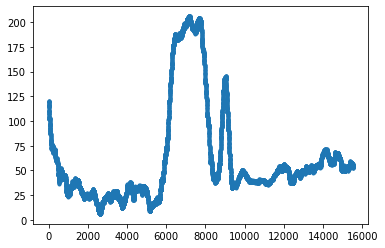

In [21]:
plt.plot(zcr, '.')

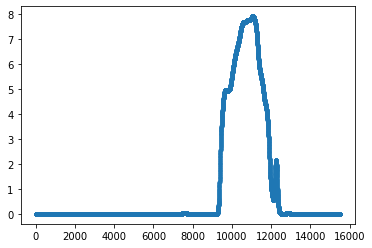

In [22]:
plt.plot(energy, '.')

In [ ]:
energyEndPointed

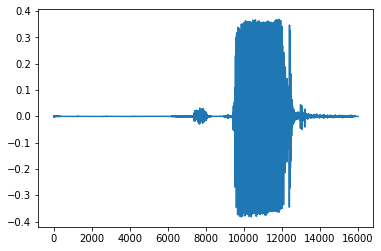

In [16]:
plt.plot(data)

---

# End pointing of the signal (CHNAGE THIS SHIT)

In [29]:
def end_pointing(sound_file, sr):
    # finding end points of the signal embedded using energy in 20ms window frames

    i = int(len(sound_file))
    ten_ms_count = int(sr*1e-2)
    sliced = []
    k = 0
    while k<= (i/ten_ms_count)-2:
        m = sound_file[k*ten_ms_count : (k+2)*ten_ms_count]
        sliced.append(m)
        k = k+1

    s = 0
    l = 0
    noise = 1 
    updated = 0
    e = int(len(sliced))-1
    h = np.hamming(ten_ms_count*2)

    while l<int(len(sliced)):  
        en = np.matmul(sliced[l]*h,sliced[l]*h)

        if(en > 0.005):
            if(noise == 1):
                noise = 0
                if updated == 0:
                    updated = 1
                    s = l

        if(en < 0.00001 and noise == 0):
            noise = 1
            e = l
            break

        l = l+1

    d = e-s
    if d < 50:
        e = int(len(sliced))-1

    new_sound_file = np.array(sound_file[s*ten_ms_count : (e+2)*ten_ms_count])
    return new_sound_file

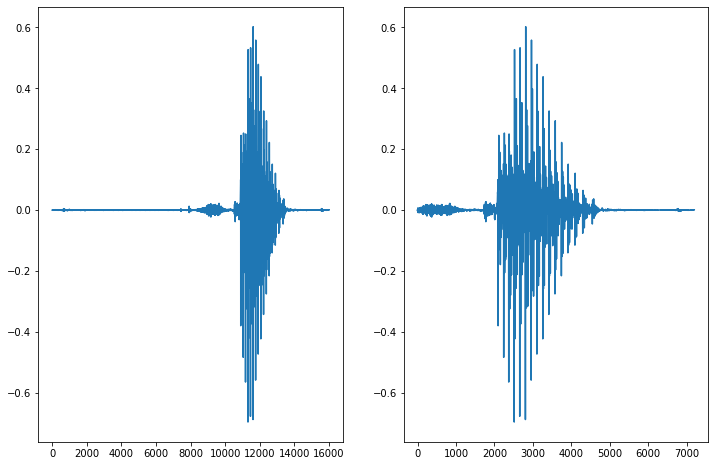

In [35]:
plt.figure(figsize=(12, 8))
str = "stop"
indx = 90
plt.subplot(121)
plt.plot(trainingData[str][indx])
plt.subplot(122)
plt.plot(end_pointing(trainingData[str][indx],sampleRate))

In [45]:
trainingLabels = [label for label in os.listdir(pathToTrainingData)]
trainingDataPreProcessed = {}
for label in trainingLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(trainingData[label])):
        soundLabelAsArray.append(applyPreEmphasis(end_pointing(trainingData[label][i], sampleRate), alpha = 0.95))
    trainingDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


In [161]:
testCleanLabels = [label for label in os.listdir(pathToCleanTest)]
cleanTestDataPreProcessed = {}
for label in testCleanLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(testCleanData[label])):
        soundLabelAsArray.append(applyPreEmphasis(end_pointing(testCleanData[label][i], sampleRate), alpha = 0.95))
    cleanTestDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


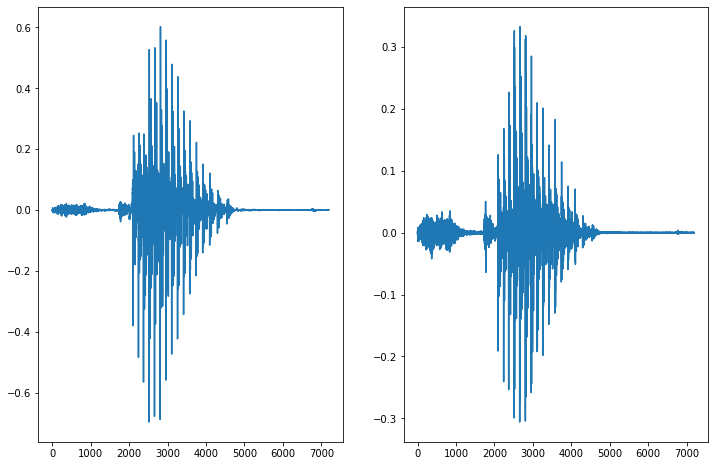

In [48]:
plt.figure(figsize=(12, 8))
str = "stop"
indx = 90
plt.subplot(121)
plt.plot(end_pointing(trainingData[str][indx],sampleRate))
plt.subplot(122)
plt.plot(trainingDataPreProcessed[str][indx])

In [156]:
mfcc = feature.mfcc(y=trainingDataPreProcessed["left"][90], sr=sampleRate, n_mfcc=13, win_length = int(0.02*sampleRate), hop_length= int(0.01*sampleRate))
delta1 = feature.delta(mfcc, order=1, mode = 'nearest')
delta2 = feature.delta(mfcc, order=2, mode = 'nearest')
np.vstack((mfcc, delta1, delta2)).shape

(39, 65)

In [155]:
mfcc.shape

(13, 65)

In [126]:
np.concatenate((mfcc, delta1, delta2), axis=0)

array([[-7.13422794e+02, -6.58643370e+02, -5.59723941e+02, ...,
        -8.62880229e+02, -8.68640496e+02, -8.81686963e+02],
       [ 2.39260702e+01,  1.20323868e+02,  1.42621110e+02, ...,
        -2.16013304e+01, -2.29665347e+01, -1.25147571e+01],
       [ 1.87761574e+01,  3.28654485e+01, -1.35954659e+01, ...,
        -3.61111399e+00, -1.69495933e+00, -1.67066868e+00],
       ...,
       [-3.22505643e-01, -6.48072462e-01, -1.27555685e+00, ...,
        -1.27284944e-01,  9.09941570e-02,  1.05558255e+00],
       [-3.03305626e+00, -2.47569361e+00, -8.90935993e-01, ...,
         3.92049328e-01, -3.49197529e-01, -7.59129847e-01],
       [-3.74170215e-01, -7.19159819e-01, -1.12360628e+00, ...,
        -1.16334284e+00, -6.74016294e-01, -6.27146216e-01]])

In [162]:
melCoef = {}
for label in trainingLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(trainingDataPreProcessed[label])):
        #n_fft = 4096, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate) set this parameters later
        mfccFeatures = feature.mfcc(y=trainingDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13)
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=2, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoef[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1760
  return f(*args, **kwargs)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1280
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'left' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'no' speech data		....finished
Finding mel filter bank output for each instace of 'off' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1440
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'on' speech data		....finished
Finding mel filter bank output for each instace of 'right' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=800
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'stop' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=960
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'up' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=320
  return f(*args, **kwargs)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=480
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'yes' speech data		....finished


In [163]:
melCoefCleanTest = {}
for label in testCleanLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(cleanTestDataPreProcessed[label])):
        #n_fft = 4096, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate) set this parameters later
        mfccFeatures = feature.mfcc(y=cleanTestDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13)
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=2, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoefCleanTest[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		....finished
Finding mel filter bank output for each instace of 'left' speech data		....finished
Finding mel filter bank output for each instace of 'no' speech data		....finished
Finding mel filter bank output for each instace of 'off' speech data		....finished
Finding mel filter bank output for each instace of 'on' speech data		....finished
Finding mel filter bank output for each instace of 'right' speech data		....finished
Finding mel filter bank output for each instace of 'stop' speech data		....finished
Finding mel filter bank output for each instace of 'up' speech data		....finished
Finding mel filter bank output for each instace of 'yes' speech data		....finished


In [80]:
trainingLabels

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

[Text(0.5, 1.0, 'MFCC')]

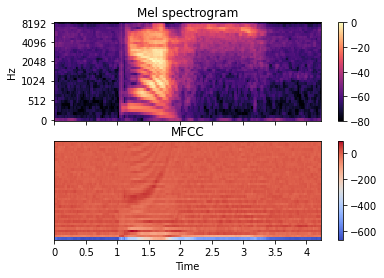

In [108]:
import librosa
import librosa.display
dur = 0.01
y, sr = trainingDataPreProcessed["yes"][90], sampleRate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate),
                                   fmax=8000)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate))
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

In [147]:
np.vstack((np.array([1,2, 3]),np.array([[1,2, 6], [1,2, 8]])))

array([[1, 2, 3],
       [1, 2, 6],
       [1, 2, 8]])

In [152]:
melCoef["down"][0].shape

(17, 39)

In [157]:
curr_train = melCoef["down"][0].T
for i in range(1, len(melCoef["down"])):
    curr_train = np.vstack((curr_train, melCoef["down"][i].T))

In [158]:
trained_model = {}
hmm_states = 9
# gmm_states = 3

print(melCoef.keys())

for word in melCoef.keys():
    print(word)
    model = hmm.GaussianHMM(n_components = hmm_states, covariance_type='full', n_iter=7)
    # model = hmm.GMMHMM(n_components=hmm_states, n_mix = gmm_states, n_iter=10 , covariance_type='full' )
    current_training_data = melCoef[word]
    l = np.zeros([len(current_training_data), ], dtype=int)
    i = 0

    while i < int(len(current_training_data)):
        l[i] = current_training_data[i].shape[1]
        i += 1
    curr_train = melCoef[word][0].T
    for i in range(1, len(melCoef[word])):
        curr_train = np.vstack((curr_train, melCoef[word][i].T))
    
    #current_training_data = np.vstack(current_training_data)
    model.fit(curr_train, lengths=l)
    trained_model[word] = model

dict_keys(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes'])
down
go
left
no
off
on
right
stop
up
yes


In [172]:
trained_model["down"].score_samples(melCoefCleanTest["down"][0].T, np.array([melCoefCleanTest["down"][0].shape[1]]).reshape((1, -1)))

(-51685252616.008064,
 array([[2.76106952e-111, 9.22831109e-005, 7.71988967e-143,
         8.75873797e-007, 1.42811518e-109, 2.52067432e-082,
         2.23541085e-066, 1.54030098e-042, 9.99908451e-001],
        [2.45089016e-140, 9.99153496e-001, 1.19610537e-185,
         8.42934830e-004, 2.20529544e-138, 9.42551035e-112,
         1.11546343e-079, 4.33884805e-061, 9.33188556e-014],
        [1.88567475e-111, 9.99809283e-001, 1.13040228e-173,
         1.89940085e-004, 7.88669674e-136, 4.20923004e-118,
         7.59478432e-068, 8.91234301e-071, 1.51451500e-047],
        [3.35834368e-039, 1.00000000e+000, 1.09036165e-113,
         2.40880079e-012, 9.76266784e-095, 1.06881731e-102,
         2.34456135e-049, 6.92179464e-064, 2.35384245e-074],
        [1.16760338e-007, 1.00000000e+000, 1.14027918e-079,
         2.59416084e-021, 3.24197281e-052, 3.24702665e-087,
         2.39601333e-052, 1.19186075e-042, 2.44013648e-063],
        [2.22648395e-268, 3.54604905e-024, 0.00000000e+000,
         2.13

In [171]:
melCoefCleanTest["down"][0].shape

(39, 17)

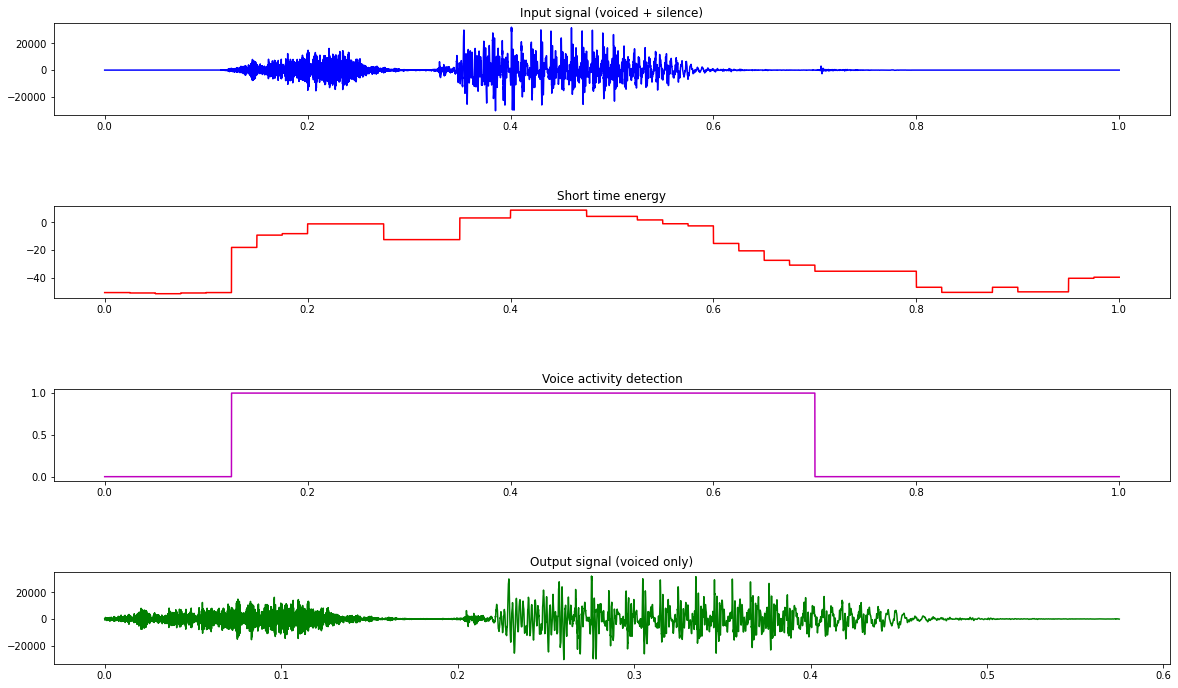

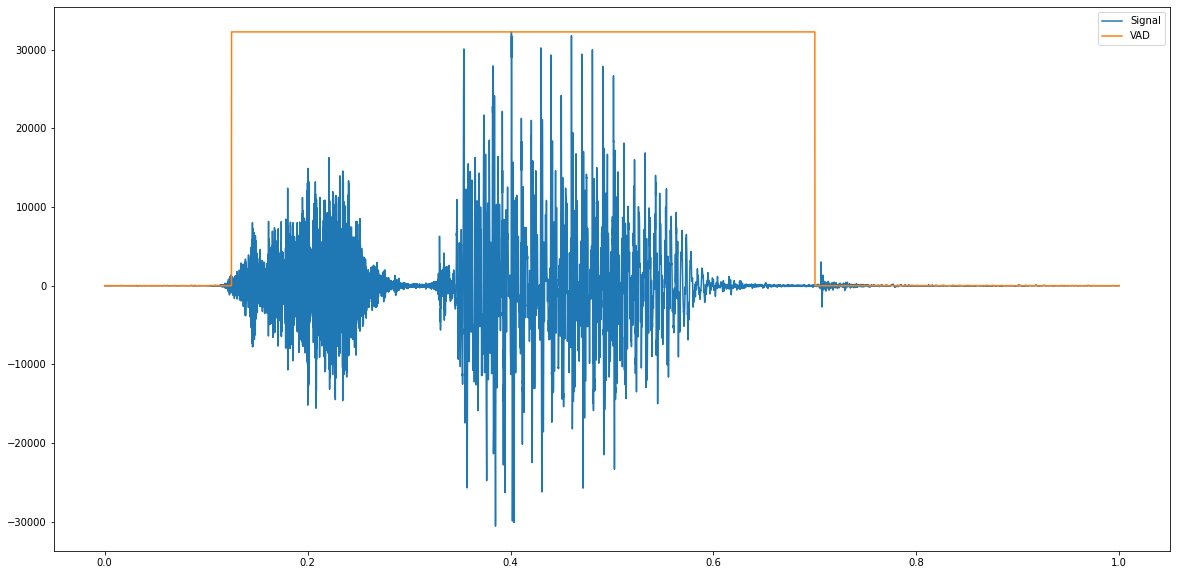

OSError: [Errno 22] Invalid argument: 'naive_frame_energy_vad_no_silence_C:\\Users\\HP\\Downloads\\Commands Dataset\\train\\stop\\0b56bcfe_nohash_0.wav'

In [138]:
import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt


def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
    """
    transform a signal into a series of overlapping frames (=Frame blocking).

    Args:
        sig     (array) : a mono audio signal (Nx1) from which to compute features.
        fs        (int) : the sampling frequency of the signal we are working with.
                          Default is 16000.
        win_len (float) : window length in sec.
                          Default is 0.025.
        win_hop (float) : step between successive windows in sec.
                          Default is 0.01.

    Returns:
        array of frames.
        frame length.

    Notes:
    ------
        Uses the stride trick to accelerate the processing.
    """
    # run checks and assertions
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()


if __name__ == "__main__":
    # init vars
    fname = "C:\\Users\\HP\\Downloads\\Commands Dataset\\train\\stop\\0b56bcfe_nohash_0.wav"
    fs, sig = scipy.io.wavfile.read(fname)

    #########################
    # naive_frame_energy_vad
    #########################
    # get voiced frames
    energy, vad, voiced = naive_frame_energy_vad(sig, fs, threshold=-35,
                                                 win_len=0.025, win_hop=0.025)

    # plot results
    multi_plots(data=[sig, energy, vad, voiced],
                titles=["Input signal (voiced + silence)", "Short time energy",
                        "Voice activity detection", "Output signal (voiced only)"],
                fs=fs, plot_rows=4, step=1)

    # save voiced signal
    scipy.io.wavfile.write("naive_frame_energy_vad_no_silence_"+ fname,
                           fs,  np.array(voiced, dtype=sig.dtype))
